# Random Fourier features

<a class="github-button" href="https://github.com/stratisMarkou/random-walks" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-star" data-size="large" data-show-count="false" aria-label="Star stratisMarkou/random-walks on GitHub">Star</a>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks/issues" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-issue-opened" data-size="large" aria-label="Issue stratisMarkou/random-walks on GitHub">Issue</a>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks/subscription" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-eye" data-size="large" aria-label="Watch stratisMarkou/random-walks on GitHub">Watch</a>
<a class="github-button" href="https://github.com/stratisMarkou" data-color-scheme="no-preference: light; light: light; dark: dark;" data-size="large" aria-label="Follow @stratisMarkou on GitHub">Follow</a>
<script async defer src="https://buttons.github.io/buttons.js"></script>

One central difficulty with Gaussian Processes (GPs), and more generally all kernel methods such as Support Vector Machines (SVMs), is their computational cost. Exact GP regression scales cubically $\mathcal{O}(N^3)$ in the number of datapoints $N,$ which is prohibitive for even modestly large datasets.
Therefore we typically have to make approximations, of which there is a wealth of possible options. This page presents Random Fourier Features (RFF), {cite}`rahimi2007random` an approximation which is applicable to stationary kernels.

RFF relies on the fact that kernels of stationary processes can be expressed as the Fourier transform of a probability density function.
This Fourier transform can then be efficiently approximated by Monte Carlo.
The samples drawn to approximate this integral are called Random Fourier Features and can be used as features for a linear-in-the-parameters Bayesian regression model, which approximates exact GP regression.
The computational cost of Bayesian linear regression is $\mathcal{O}(\min\{N^3, M^3\})$ where $M$ is the number of regression features, so by using $M < N$ we can significantly reduce the cost of the algorithm.
Further, one can prove that the covariance function induced by RFF closely approximates that of the exact GP with a relatively small number of samples. Lastly, RFF is rather easy to implement in practice.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## The RFF approximation

The starting point for deriving RFF is Bochner's theorem, which relates stationary kernels with probability distributions over frequencies via the Fourier transform.

:::{prf:theorem} Bochner's theorem

A continuous function of the form $k(x, y) = k(x - y)$ is positive definite if and only if $k(\delta)$ is the Fourier transform of a non-negative measure.
:::

Note that this statement slightly abuses the $k$ symbol, using it to denote both the kernel $k(x, y)$ as well as its writing in an explicitly translation-invariant form $k(x - y)$ - the implied use is clear from context.
From Bochner's theorem, we see that we can express any positive definite measure as the Fourier transform of a probability measure, rather than simply a non-negative measure, by introducing an appropriate scaling constant $\sigma^2$, that is

$$\begin{align}
k(x - y) = \sigma^2 \int p(\omega) e^{-i \omega^\top (x - y)} d\omega = \sigma^2 \mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right].
\end{align}$$

Thus, we can get an unbiased estimate of $k(x - y)$ by sampling $\omega \sim p(\omega)$ and computing $\zeta_{\omega}(x)\zeta_{\omega}^*(y).$
Note however, that even though $\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right]$ is real, the sampled $\zeta_{\omega}(x)\zeta_{\omega}^*(y)$ will in general be complex.
This is an issue if we want to use $\zeta_{\omega}$ to represent real functions. To resolve this issue, we can write the integral as

$$\begin{align}
\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right] &= \text{Re}\left[\mathbb{E}_{\omega}\left[e^{-i \omega^\top (x - y)}\right]\right] \\
                                                                     &= \mathbb{E}_{\omega}\left[\text{Re}\left[e^{-i \omega^\top (x - y)}\right]\right] \\
                                                                     &= \mathbb{E}_{\omega}\left[\cos(\omega^\top (x - y))\right],
\end{align}$$

which has a real-valued integrand, so a Monte Carlo estimate of it will always be real valued.
Next, we would like to manipulate the expression above into an expectation of the form $\mathbb{E}_{\omega}\left[r_{\omega}(x)r_{\omega}(y)\right]$ rather than $\mathbb{E}\left[r_{\omega}(x - y)\right]$.
In this way, we will be able to interpret this expectation as the covariance of a Bayesian regression model - this will be clarified shortly. Using the fact that

$$\begin{align}
\mathbb{E}_{\phi}\left[\cos(z + n\phi)\right] = 0,
\end{align}$$

for all $z \in \mathbb{R}, n \in \mathbb{N}^+$, where $\phi \sim \text{Uniform}[0, 2\pi]$, we can re-write the expectation as

$$\begin{align}
\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right] &= \mathbb{E}_{\omega, \phi}\left[\cos\left(\omega^\top (x - y)\right) + \cos\left(\omega^\top (x + y\right) + 2b)\right] \\
                                                                     &= \mathbb{E}_{\omega, \phi}\left[2 \cos\left(\omega^\top x + b\right) \cos\left(\omega^\top y + b\right)\right].
\end{align}$$

We can therefore get an unbiased, real valued estimate of $k(x - y)$ by sampling $\omega, \phi$ and computing

$$\begin{align}
\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right] \approx z_{\omega, b}(x) z_{\omega, b}(y), \text{ where } z_{\omega, b}(x) = \sqrt{2} \cos(\omega^\top x + b).
\end{align}$$

In fact, we can go a bit further by drawing $M$ independent pairs of $\omega, b$ and computing the estimate

$$\begin{align}
\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right] \approx \frac{1}{M} \sum_{m = 1}^M z_{\omega_m, \phi_m}(x) z_{\omega_m, \phi_m}(y).
\end{align}$$

This is also an unbiased estimate of the kernel, however its variance is lower than in the $M = 1$ case, since the variance of the average of the sum of $K$ i.i.d. random variables is lower than the variance of a single one of the variables. 
We therefore arrive at the following algorithm for estimating $k$.

:::{prf:definition} Random Fourier Features

Given a translation invariant kernel $k$ that is the Fourier transform of a probability measure $p$, we have the unbiased real-valued estimator
    
$$\begin{align}
k(x - y) \approx \frac{1}{M} \sum_{m = 1}^M z_{\omega_m, \phi_m}(x) z_{\omega_m, \phi_m}(y) = z^\top(x)z(y),
\end{align}$$
    
where we have used the notation $z(x) = \left[ z_{\omega_1, \phi_1}(x), ..., z_{\omega_M, \phi_M}(x) \right]^\top$ and $\omega_m \sim p(\omega), \phi_m \sim \text{Uniform}[0, 2\pi]$ are independent and identically distributed samples.
:::

### RFF and Bayesian regression

Now we are in a position to interpret this expression in terms of a Bayesian regression model. Consider the regressor

$$\begin{align}
f(x) = z^\top(x)w, \text{ where } w \sim \mathcal{N}(0, I),
\end{align}$$

where $z(x)$ is as defined above. This is a Bayesian regression model which uses Random Fourier Features. Therefore we can approximate the exact GP regressor by a Bayesian linear regressor with Random Fourier Features.

### Rates of convergence

Now there remains the question of how large the error of the RFF estimator is. In other words, how closely does RFF estimate the exact kernel $k$? Since $-\sqrt{2} \leq z_{\omega, \phi} \leq \sqrt{2}$, we can use Hoeffding's inequality{cite}`grimmett2020probability` to obtain the following high-probability bound on the absolute error on our estimate of $k$.

:::{prf:lemma} Hoeffding for RFF

The RFF estimator of $k$, using $M$ pairs of $\omega, \phi$, obeys
    
$$\begin{align}
p\big(|z^\top(x)z(y) - k(x, y)| \geq \epsilon \big) \leq 2 \exp\left(-M \frac{\epsilon^2}{4}\right).
\end{align}$$
:::

Therefore for any given input pair, the error of the RFF estimator decays exponentially quickly with $M$.
Note that this is a statement about the closeness of $z^\top(x)z(y)$ and $k(x, y)$ for any two input pairs, rather than the closeness of these functions over the whole input space.
In fact, it is possible{cite}`rahimi2007random` to make a stronger statement about the uniform convergence of the estimator.

:::{prf:lemma} Uniform convergence of RFF

Let $\mathcal{M}$ be a compact subset of $\mathbb{R}^D$. Then the RFF estimator of $k$, using $M$ pairs of $\omega, \phi$ converges uniformly to $k$ according to
    
$$\begin{align}
p~\Bigg(\sup_{x, y \in \mathcal{M}}|z^\top(x)z(y) - k(x, y)| \geq \epsilon \Bigg) \leq \frac{C}{\epsilon^2} \exp\left(-\frac{M\epsilon^2}{4(d + 2)}\right).
\end{align}$$
:::

## Implementation

We now turn to an implementation of RFF.
We consider approximating the same three kernels which were presented in the RFF paper, namely the EQ (or Gaussian) kernel, the Laplace kernel and the Cauchy kernel.

In [2]:
def sample_rff(
    x,
    kernel,
    lengthscale,
    coefficient,
    num_functions,
    num_features,
):
    
    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_functions, num_features, x_dim)
    
    # Handle each of three possible kernels separately
    if kernel == 'eq':
        omega = np.random.normal(size=omega_shape)
        
    elif kernel == 'laplace':
        omega =  np.random.standard_cauchy(size=omega_shape)
        
    elif kernel == 'cauchy':
        omega = np.random.laplace(size=omega_shape)
        
    # Scale omegas by lengthscale
    omega = omega / lengthscale
    
    weights = np.random.normal(
        loc=0.,
        scale=1.,
        size=(num_functions, num_features),
    )
    
    phi = np.random.uniform(
        low=0.,
        high=(2 * np.pi),
        size=(num_functions, num_features, 1),
    )
    
    features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / num_features) ** 0.5 * features * coefficient
    
    functions = np.einsum('sf, sfn -> sn', weights, features)
    
    return functions, features

### Sampling from the prior

We can now visualise functions sampled from the prior induced by RFF.
Each function corresponds to a different sample set $\{(\omega_m, \phi_m)\}_{m = 1}^M$ as well as a different weight vector $w$.
The covariance function plots correspond to the RFF estimator of $k$, using a single sample of RFF parameters.

In [3]:
# Kernels to approximate
kernels = ['eq', 'laplace', 'cauchy']

# Kernel parameters, # function samples, # features for each function
lengthscale = 1.
coefficient = 1.
num_functions = 100
num_features = 200

# Input locations
x = np.linspace(-3., 3., 100)[:, None]

# Draw random fourier features and functions
samples = [
    sample_rff(
        x=x, 
        kernel=kernel, 
        lengthscale=lengthscale, 
        coefficient=coefficient, 
        num_functions=num_functions, 
        num_features=num_features,
    )
    for kernel in kernels
]

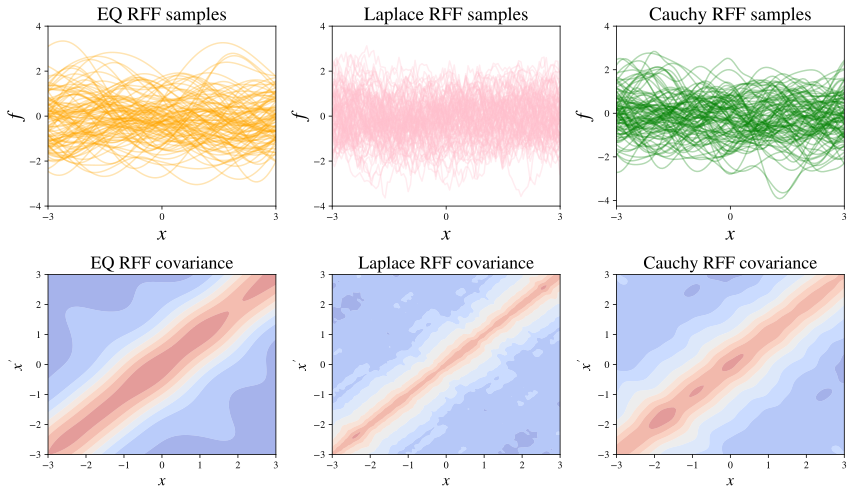

In [4]:
# Titles for sample plots
sample_titles = [
    'EQ RFF samples',
    'Laplace RFF samples',
    'Cauchy RFF samples',
]

# Titles for kernel plots
kernel_titles = [
    'EQ RFF covariance',
    'Laplace RFF covariance',
    'Cauchy RFF covariance',
]

colors = ['orange', 'pink', 'green']

# Plot samples and linear model covariances
plt.figure(figsize=(12,7))

for i in range(3):

    functions, features = samples[i]

    # Figure to plot on
    plt.subplot(2, 3, i + 1)

    # Plot sampled functions
    plt.plot(x, functions.T, color=colors[i], alpha=0.3)
    
    # Format plot
    plt.xlim([x.min(), x.max()])
    plt.xlabel("$x$", fontsize=20)
    plt.ylabel("$f$", fontsize=20)
    plt.xticks(np.linspace(-3, 3, 3))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.title(sample_titles[i], fontsize=19)

    plt.subplot(2, 3, i + 4)

    # Plot covariances
    x1, x2 = np.meshgrid(x, x)
    cov = np.einsum('ij, ik -> jk', features[0], features[0])
    plt.contourf(x1, x2, cov, cmap="coolwarm", alpha=0.5)
    
    # Format plot
    plt.xlabel("$x$", fontsize=16)
    plt.ylabel("$x'$", fontsize=16)
    plt.title(kernel_titles[i], fontsize=18)
    
plt.tight_layout()
plt.show()

### Regression with RFF features

First we generate a toy dataset from a noisy sinusoid.
We place a gap in the data to observe the quality of the uncertainty estimates of the RFF regressor.
We purposefully use a large number of datapoints, $N = 5000,$ which would be quite slow to process with an exact GP model.

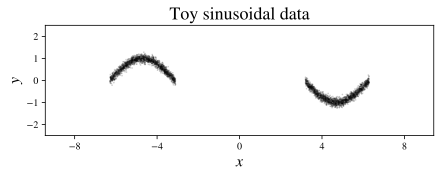

In [5]:
# Number of datapoints to generate
num_data = 4000

# Generate sinusoidal data with a gap in input space
x_data = 4 * np.pi * (np.random.uniform(size=(4 * num_data // 2, 1)) - 0.5)
x_data = np.sort(x_data, axis=0)
x_data = np.concatenate(
    [
        x_data[:(x_data.shape[0]//4)],
        x_data[-(x_data.shape[0]//4):]
    ],
    axis=0,
)
y_data = np.sin(x_data) + 1e-1 * np.random.normal(size=x_data.shape)
        
# Plot data
plt.figure(figsize=(7, 2))
    
# Plot data points
plt.scatter(x_data, y_data, marker='+', color='k', s=1, alpha=0.2)

# Format plot
plt.title('Toy sinusoidal data', fontsize=18)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.xticks(np.linspace(-8, 8, 5))
plt.yticks(np.linspace(-2, 2, 5))
plt.xlim([1.5 * x_data.min(), 1.5 * x_data.max()])
plt.ylim([-2.5, 2.5])
plt.show()

The function `rff_posterior` below implements Bayesian linear regression with randomly sampled Fourier features.
For more details on Bayesian linear regression see Chapter 3 of Bishop's PRML book.{cite}`bishop2006pattern`

In [6]:
def rff_posterior(
    x_data,
    y_data,
    x_pred,
    kernel,
    lengthscale,
    coefficient,
    num_features,
    noise,
):
    
    num_data = x_data.shape[0]
    x_full = np.concatenate([x_pred, x_data])
    
    _, features = sample_rff(
        x=x_full, 
        kernel=kernel, 
        lengthscale=lengthscale, 
        coefficient=coefficient, 
        num_functions=1, 
        num_features=num_features,
    )
    features = features[0]
    
    features_pred = features[:, :-num_data]
    features_data = features[:, -num_data:]
    
    iS = np.eye(features_data.shape[0]) + \
        features_data @ features_data.T * noise ** -2

    mean_pred = noise ** -2 * \
        features_pred.T @ np.linalg.solve(iS, features_data @ y_data)[:, 0]
    
    var_pred = np.einsum(
        'fn, fn -> n',
        features_pred,
        np.linalg.solve(iS, features_pred),
    )
    
    return mean_pred, var_pred

Now we perform Bayesian linear regression with RFF features for each of the three kernels.
The two helpers below, implement exact GP regression.
The `covariance` helper implements the EQ, Laplace and Cauchy covariance functions and the `exact_gp_posterior` helper performs exact GP regression. {cite}`rasmussen2003gaussian`

In [7]:
def covariance(x1, x2, kernel, lengthscale, coefficient, noise=None):
    
    diff = x1[:, None, :] - x2[None, :, :]
    
    if kernel == 'eq':
        l2 = np.sum((diff / lengthscale) ** 2, axis=2)
        cov = coefficient ** 2 * np.exp(-0.5 * l2)
        
    elif kernel == 'laplace':
        l1 = np.sum(np.abs(diff / lengthscale), axis=2)
        cov = coefficient ** 2 * np.exp(-0.5 * l1)
        
    elif kernel == 'cauchy':
        l2 = np.sum((diff / lengthscale) ** 2, axis=2)
        cov = coefficient ** 2 / (1 + l2)
        
    if noise is not None:
        cov = cov + noise ** 2 * np.eye(cov.shape[0])
    
    return cov


def exact_gp_posterior(x_data, y_data, x_pred, kernel, lengthscale, coefficient, noise):
    
    Kdd = covariance(x_data, x_data, kernel, lengthscale, coefficient, noise)
    Kpd = covariance(x_pred, x_data, kernel, lengthscale, coefficient, None)
    Kpp = covariance(x_pred, x_pred, kernel, lengthscale, coefficient, None)
    
    mean = Kpd @ np.linalg.solve(Kdd, y_data[:, 0])
    var = np.diag(Kpp - Kpd @ np.linalg.solve(Kdd, Kpd.T))
    
    return mean, var

Timing the computation shows that the RFF implementation takes miliseconds to execute, as opposed to exact GP regression which takes much longer.

In [8]:
# Kernels to approximate
kernels = ['eq', 'laplace', 'cauchy']

# Kernel parameters and # of RFF features to use
lengthscale = 1e0
coefficient = 1e0
num_features = 200

# Noise level used by regressor
noise = 1e-1

# Locations to make predictions at
x_pred = np.linspace(
    1.5 * x_data.min(),
    1.5 * x_data.max(),
    100,
)[:, None]

In [9]:
print('Timing exact GP regression:\n')

%time exact_posteriors = [ \
    exact_gp_posterior(    \
        x_data,            \
        y_data,            \
        x_pred,            \
        kernel,            \
        lengthscale,       \
        coefficient,       \
        noise,             \
    )                      \
    for kernel in kernels  \
]

Timing exact GP regression:

CPU times: user 40.1 s, sys: 13.3 s, total: 53.4 s
Wall time: 13.1 s


In [10]:
print('Timing exact approximate RFF regression:\n')

np.random.seed(0)

%time approx_posteriors = [  \
    rff_posterior(           \
        x_data,              \
        y_data,              \
        x_pred,              \
        kernel,              \
        lengthscale,         \
        coefficient,         \
        num_features,        \
        noise)               \
    for kernel in kernels    \
]

Timing exact approximate RFF regression:

CPU times: user 2.06 s, sys: 1.55 s, total: 3.61 s
Wall time: 806 ms


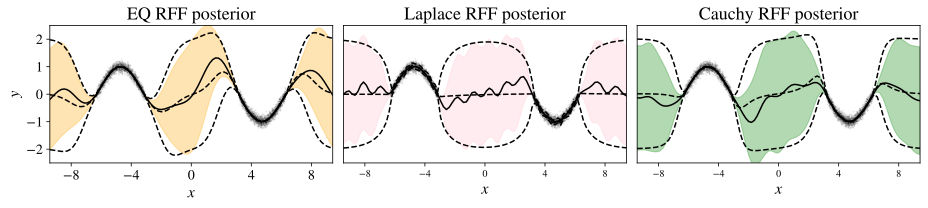

In [11]:
# Titles for sample plots
posterior_titles = [
    'EQ RFF posterior',
    'Laplace RFF posterior',
    'Cauchy RFF posterior',
]

colors = ['orange', 'pink', 'green']

plt.figure(figsize=(13, 3))

for i in range(3):

    approx_mean, approx_var = approx_posteriors[i]
    exact_mean, exact_var = exact_posteriors[i]

    plt.subplot(1, 3, i + 1)
    
    # Plot approximate posterior
    plt.plot(x_pred[:, 0], approx_mean, color='k')
    plt.fill_between(x_pred[:, 0],
                     approx_mean - 2 * approx_var ** 0.5,
                     approx_mean + 2 * approx_var ** 0.5,
                     color=colors[i],
                     alpha=0.3)
    
    # Plot approximate posterior
    plt.plot(x_pred[:, 0], exact_mean, '--', color='k')
    plt.plot(x_pred[:, 0], exact_mean - 2 * exact_var ** 0.5, '--', color='k')
    plt.plot(x_pred[:, 0], exact_mean + 2 * exact_var ** 0.5, '--', color='k')
    
    # Plot data
    plt.scatter(x_data, y_data, marker='+', color='k', s=1, alpha=0.1)
    
    # Format plot
    plt.title(posterior_titles[i], fontsize=18)
    plt.xlabel("$x$", fontsize=16)
    plt.xlim([x_pred.min(), x_pred.max()])
    plt.xticks(np.linspace(-8, 8, 5))
    plt.ylim([-2.5, 2.5])
    
    if i == 0:
        plt.xticks(fontsize=14)
        plt.yticks(np.linspace(-2, 2, 5), fontsize=14)
        plt.ylabel("$y$", fontsize=16)
        
    else:
        plt.yticks([])
    
plt.tight_layout()
plt.show()

RFF has produced sensible regressors in each case, significantly faster than exact GP regression. The approximate posteriors roughly match the exact posteriors, while being significantly quicker to compute.

### Variance starvation

One issue with the RFF is that - like all other finte basis function models - is that it has a limited amount of degrees of freedom. Therefore, in some situations the datapoints may be such that they pin down the RFF model and significantly reducing the variance of the approximate regressor. To illustrate this, we sample a slightly different dataset, with a smaller gap in between the two data clumps.

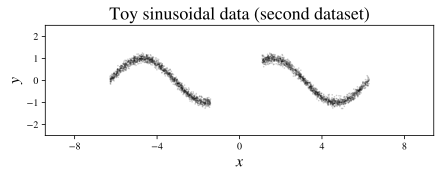

In [12]:
# Number of datapoints to generate
num_data = 3000

# Generate sinusoidal data with a gap in input space
x_data = 4 * np.pi * \
    (np.random.uniform(size=(5 * num_data // 4, 1)) - 0.5)
x_data = np.sort(x_data, axis=0)
x_data = np.concatenate(
    [
        x_data[:(2*x_data.shape[0]//5)],
        x_data[-(2*x_data.shape[0]//5):],
    ],
    axis=0,
)
y_data = np.sin(x_data) + 1e-1 * np.random.normal(size=x_data.shape)
        
# Plot data
plt.figure(figsize=(7, 2))
    
# Plot data points
plt.scatter(x_data, y_data, marker='+', color='k', s=1, alpha=0.2)

# Format plot
plt.title('Toy sinusoidal data (second dataset)', fontsize=18)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.xticks(np.linspace(-8, 8, 5))
plt.yticks(np.linspace(-2, 2, 5))
plt.xlim([1.5 * x_data.min(), 1.5 * x_data.max()])
plt.ylim([-2.5, 2.5])
plt.show()

In [13]:
np.random.seed(0)

exact_posteriors = [        \
    exact_gp_posterior(     \
        x_data,             \
        y_data,             \
        x_pred,             \
        kernel,             \
        lengthscale,        \
        coefficient,        \
        noise,              \
    )                       \
    for kernel in kernels   \
]

approx_posteriors = [     \
    rff_posterior(        \
        x_data,           \
        y_data,           \
        x_pred,           \
        kernel,           \
        lengthscale,      \
        coefficient,      \
        num_features,     \
        noise,            \
    )                     \
    for kernel in kernels \
]

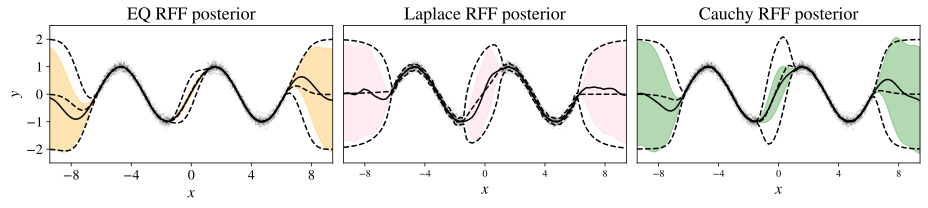

In [14]:
# Titles for sample plots
posterior_titles = [
    'EQ RFF posterior',
    'Laplace RFF posterior',
    'Cauchy RFF posterior',
]

colors = ['orange', 'pink', 'green']

plt.figure(figsize=(13, 3))

for i in range(3):

    approx_mean, approx_var = approx_posteriors[i]
    exact_mean, exact_var = exact_posteriors[i]

    plt.subplot(1, 3, i + 1)
    
    # Plot approximate posterior
    plt.plot(x_pred[:, 0], approx_mean, color='k')
    plt.fill_between(
        x_pred[:, 0],
        approx_mean - 2 * approx_var ** 0.5,
        approx_mean + 2 * approx_var ** 0.5,
        color=colors[i],
        alpha=0.3,
    )
    
    # Plot approximate posterior
    plt.plot(x_pred[:, 0], exact_mean, '--', color='k')
    plt.plot(x_pred[:, 0], exact_mean - 2 * exact_var ** 0.5, '--', color='k')
    plt.plot(x_pred[:, 0], exact_mean + 2 * exact_var ** 0.5, '--', color='k')
    
    # Plot data
    plt.scatter(x_data, y_data, marker='+', color='k', s=1, alpha=0.1)
    
    # Format plot
    plt.title(posterior_titles[i], fontsize=18)
    plt.xlabel("$x$", fontsize=16)
    plt.xlim([x_pred.min(), x_pred.max()])
    plt.xticks(np.linspace(-8, 8, 5))
    plt.ylim([-2.5, 2.5])
    
    if i == 0:
        plt.xticks(fontsize=14)
        plt.yticks(np.linspace(-2, 2, 5), fontsize=14)
        plt.ylabel("$y$", fontsize=16)
        
    else:
        plt.yticks([])
    
plt.tight_layout()
plt.show()

The variance of the approximate estimator in between the data is (in some cases), signiticantly smaller than that of the exact posterior. So the speedup that the RFF gives does not come without a cost. In certain cases, we can end up with approximate posteriors which are significantly overfitted. This can be alleviated by increasing the number of RFF features. However this increases the computational cost of performing regression and may defeat the purpose of using RFF features in the first place.

## Conclusion

Random Fourier Features are a cheap and efficient way to sample from a Gaussian Process (GP) prior. By using a finite number of features $M$, smaller than the number of datapoints $N$, allows us to perform approximate GP regression, reducing the computational complexity from $\mathcal{O}(N^3)$ to $\mathcal{O}(NM^2)$, where $M$ is the number of random features. Some interesting recent work{cite}`wilson2020efficiently` combines RFF with sparse GP approximations to produce approximate GP regressors which are both cheap to train as well as to sample form their posteriors.

## References

```{bibliography}
:filter: docname in docnames
```